In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models
from torchvision import transforms
from torchvision.transforms import functional
from PIL import Image

In [2]:
#with lines/circles
lines = "/content/drive/MyDrive/maps/карта 15.png"
# without lines/circles
nolines = "/content/drive/MyDrive/maps/карта 14.jpg"


In [3]:
pic = cv2.imread(lines)
pic2 = cv2.imread(nolines)


In [4]:
# def generate_mask(pic):
#     upper = np.array([255, 100, 255])
#     lower = np.array([160, 0, 170])

#     mask = cv2.inRange(pic, lower, upper)
#     mask = cv2.bitwise_and(pic, pic, mask = mask)

#     NEW_PINK = [255,100,255]
#     # making the layer a uniform pink
#     for i in np.arange(mask.shape[0]):
#       for j in np.arange(mask.shape[1]):
#         if not np.sum(mask[i][j]) == 0:
#           pic[i][j] = NEW_PINK

#     # getting a grayscale mask
#     white_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
#     return mask
#     # cv2_imshow(np.hstack([pic, pink_mask]))


In [5]:
def generate_figures(PIC, LINE_COLOR, CIRCLE_RADIUS, NUM_CIRCLES, LINE_THICKNESS):

    # circle center coordinates
    coords = []

    lined_pic = np.copy(PIC)

    # NUM_CIRCLES circles, not overlapping
    for i in np.arange(NUM_CIRCLES):
      overlap = True

      while (overlap):
        is_good = True
        new_Coord = [random.randrange(int(PIC.shape[1] / 6), int(PIC.shape[1] * 5 / 6)), random.randrange(int(PIC.shape[0] / 6), int(PIC.shape[0] * 5 / 6))]
        for other_Coord in coords:
          if math.dist(new_Coord, other_Coord) < 110:
            is_good = False
        if is_good:
          overlap = False
      coords.append(new_Coord)
      cv2.circle(lined_pic, new_Coord, CIRCLE_RADIUS, LINE_COLOR, LINE_THICKNESS)
      # LABELS for circles
      cv2.putText(lined_pic, str(i), new_Coord, cv2.FONT_HERSHEY_DUPLEX, 1.2, LINE_COLOR, LINE_THICKNESS, cv2.LINE_AA)

    # lines connecting circles
    for i in np.arange(NUM_CIRCLES - 1):
      adj = coords[i][1] - coords[i+1][1]
      opp = coords[i][0] - coords[i+1][0]
      hyp = math.sqrt(adj * adj + opp * opp)
      sin = opp/hyp
      cos = adj/hyp
      center1 = [int(coords[i][0] -  sin*CIRCLE_RADIUS), int(coords[i][1] - cos*CIRCLE_RADIUS)]
      center2 = [int(coords[i+1][0] +  sin*CIRCLE_RADIUS), int(coords[1+i][1] + cos*CIRCLE_RADIUS)]
      line_coord = [center1, center2]
      cv2.line(lined_pic, line_coord[0], line_coord[1], LINE_COLOR, LINE_THICKNESS)

    return lined_pic




In [6]:
def generate_mask(pic, color):
    upper = np.array([color[0] + 1, color[1] + 1, color[2] + 1])
    lower = np.array([color[0] - 1, color[1] - 1, color[2] - 1])

    mask = cv2.inRange(pic, lower, upper)
    pink_mask = cv2.bitwise_and(pic, pic, mask = mask)
    return pink_mask

In [7]:
# Training data should me maps with existing labels
path = "/content/drive/MyDrive/maps/"
data_with_labels = [path+element for element in ["карта 15.png", "карта 13.jpg", "карта 10.png", "карта 9.png", "карта 8.png", "карта 7.png", "карта 6.png",  "карта 5.png"]]
training_data = [path+element for element in ["карта 14.jpg", "карта 12.jpg", "Kartta 106 - 2017.jpg", "Kartta 12 - 2018.jpg"]]
print(training_data)
validation_data = [path+"карта 11.jpg"]

['/content/drive/MyDrive/maps/карта 14.jpg', '/content/drive/MyDrive/maps/карта 12.jpg', '/content/drive/MyDrive/maps/Kartta 106 - 2017.jpg', '/content/drive/MyDrive/maps/Kartta 12 - 2018.jpg']


In [8]:
def generate_image(data, n):
  for i in range(n):
    pic = cv2.imread(data)
    x = 800 / pic.shape[0] * random.uniform(1, 1.3)
    pic = cv2.resize(pic, (int(pic.shape[0] * x), int(pic.shape[1] * x)))
    r = random.randrange(0, 4)
    if r == 1:
      pic = cv2.rotate(pic, cv2.ROTATE_90_CLOCKWISE)
    elif r == 2:
      pic = cv2.rotate(pic, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif r == 3:
      pic = cv2.rotate(pic, cv2.ROTATE_180)
    b, g, r, circle_radius, num_circles, line_thickness = random.randrange(0, 255), random.randrange(0, 100), random.randrange(160, 255), random.randrange(25, 50), random.randrange(5, 15), random.randrange(2, 5)
    color = [b, g, r]
    lined_pic = generate_figures(pic, color, circle_radius, num_circles, line_thickness)
    mask = generate_mask(lined_pic, color)
    return pic, lined_pic, mask



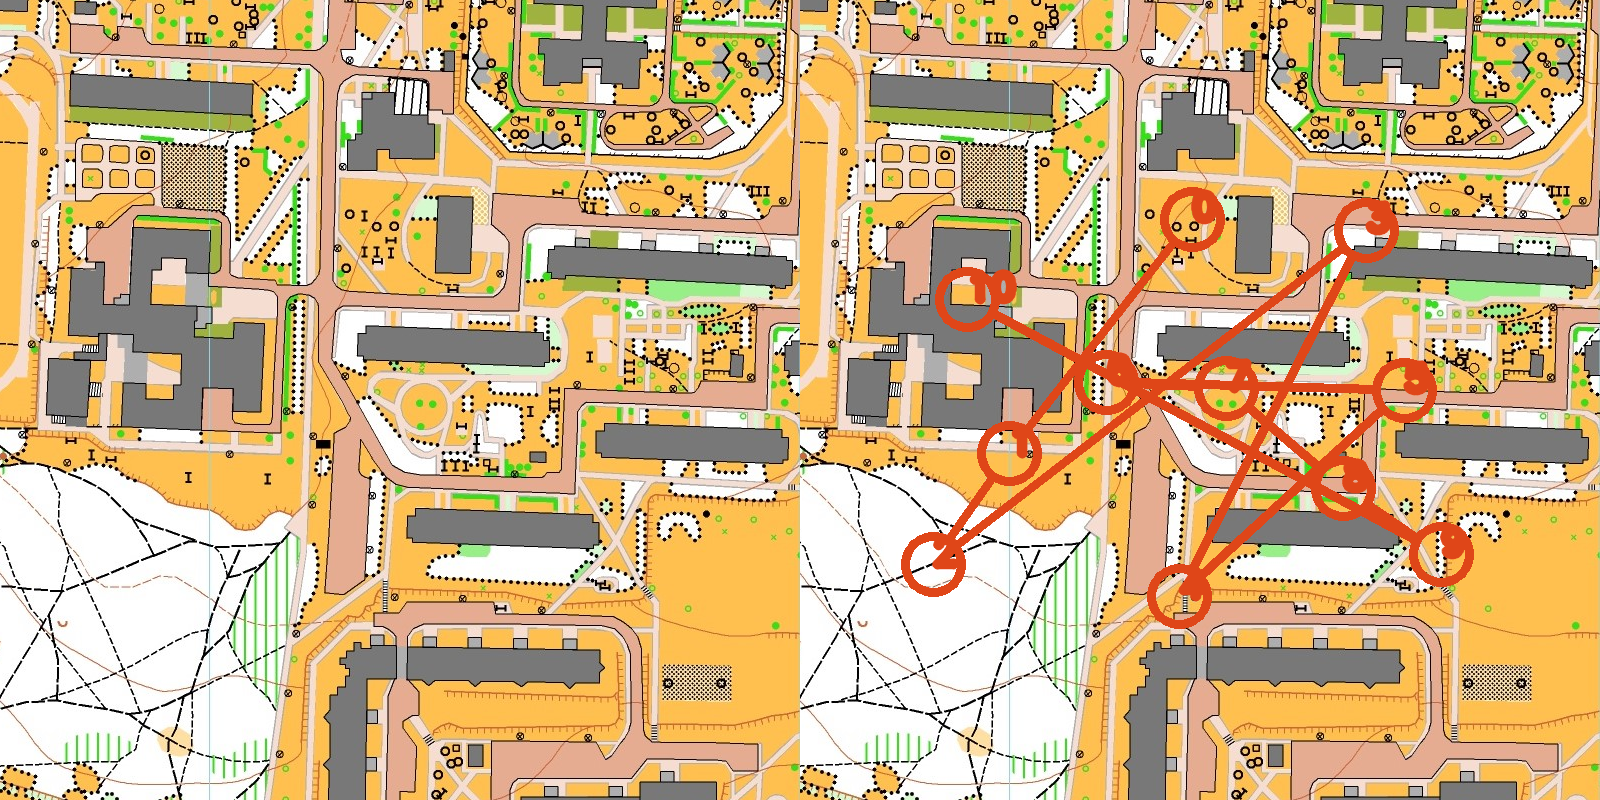

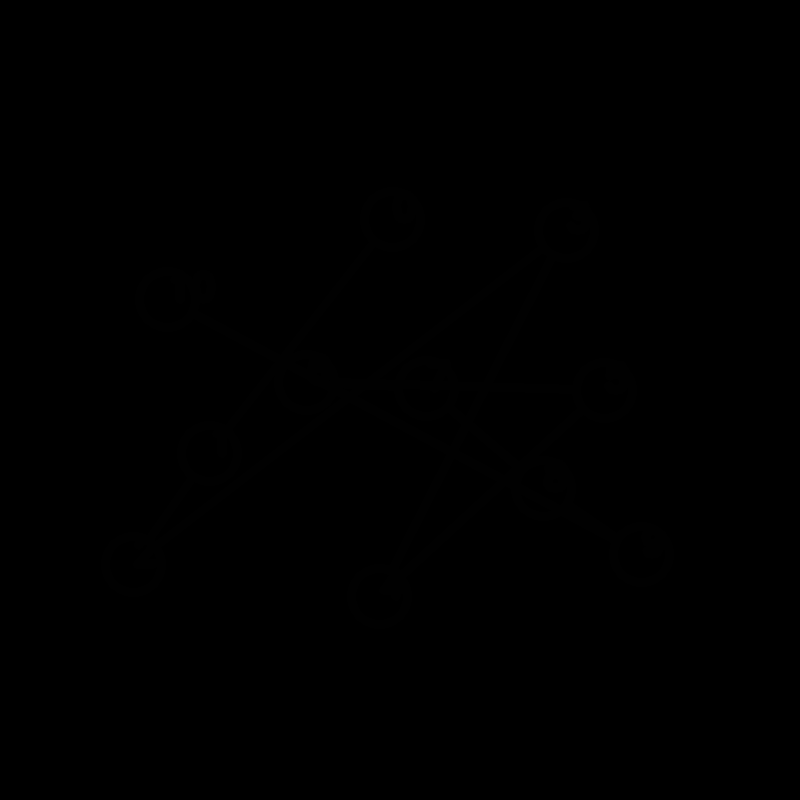

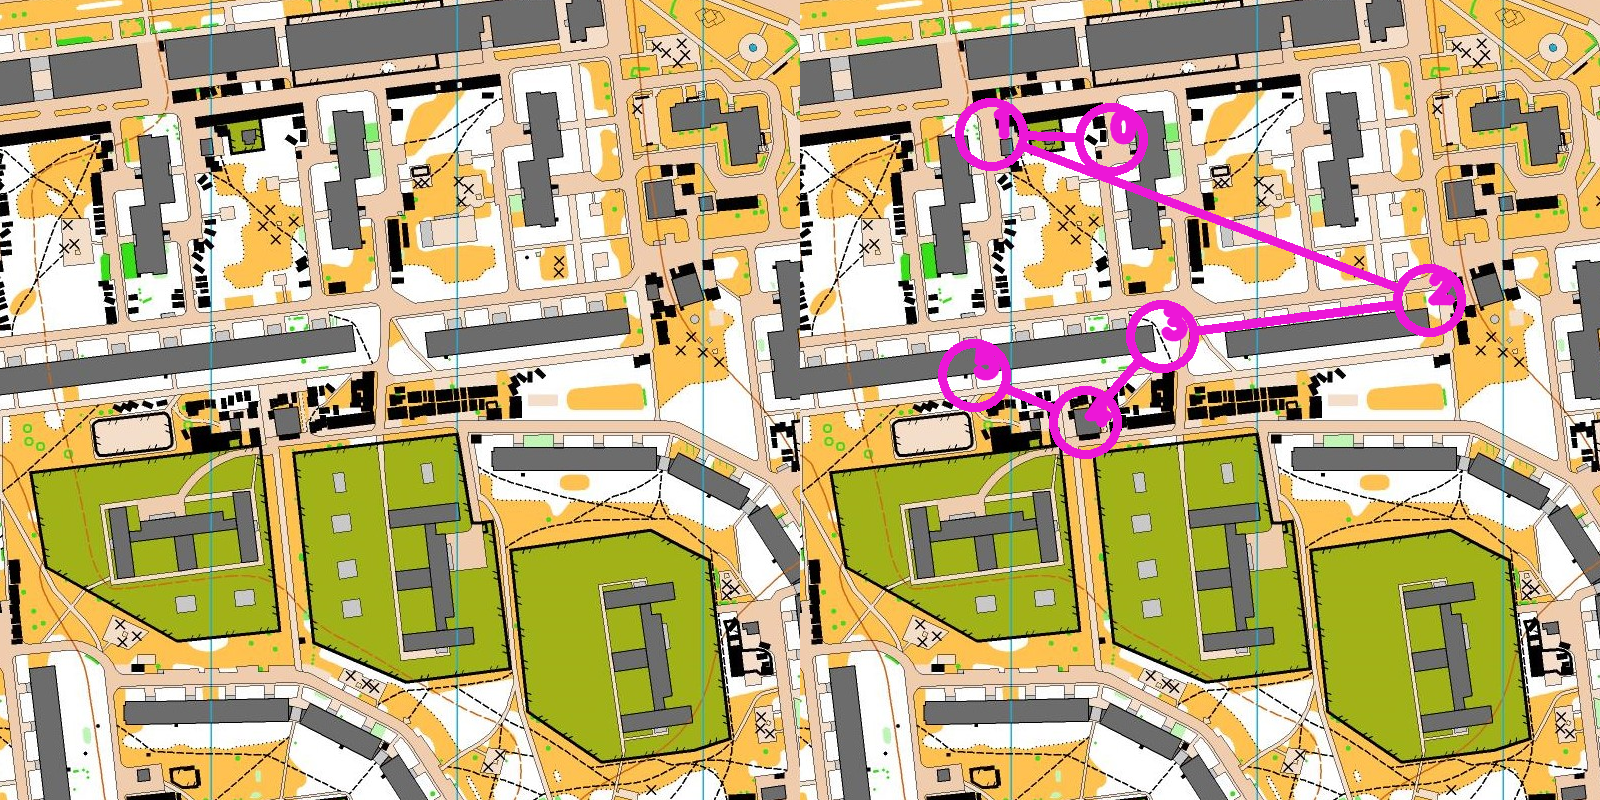

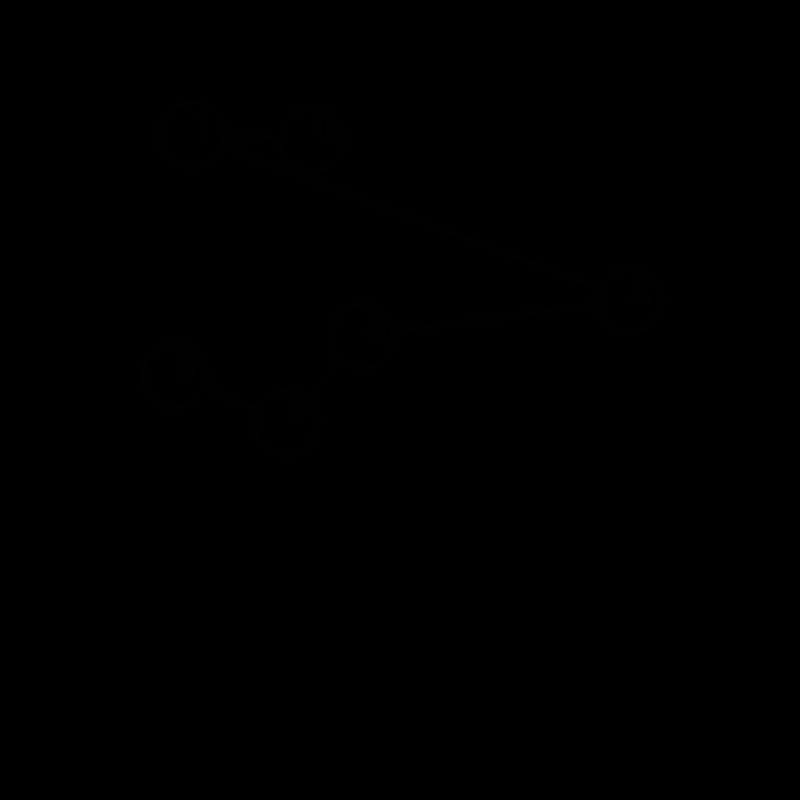

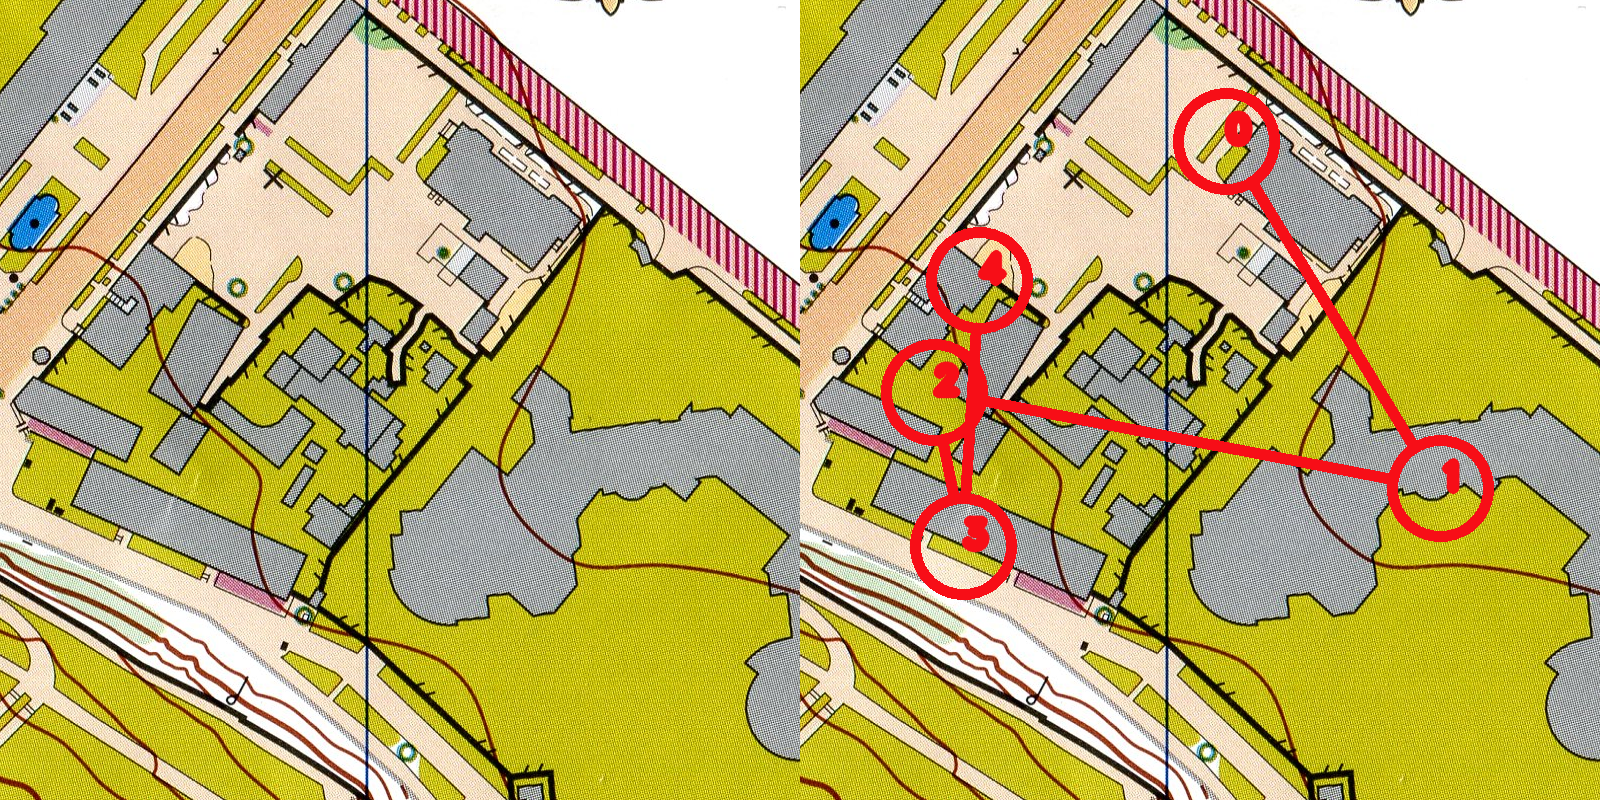

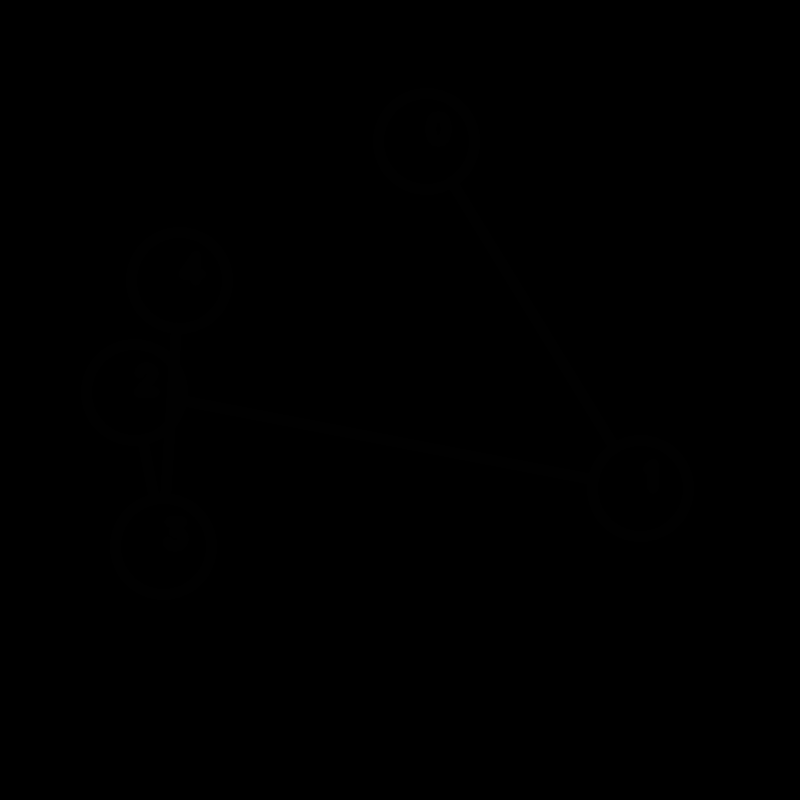

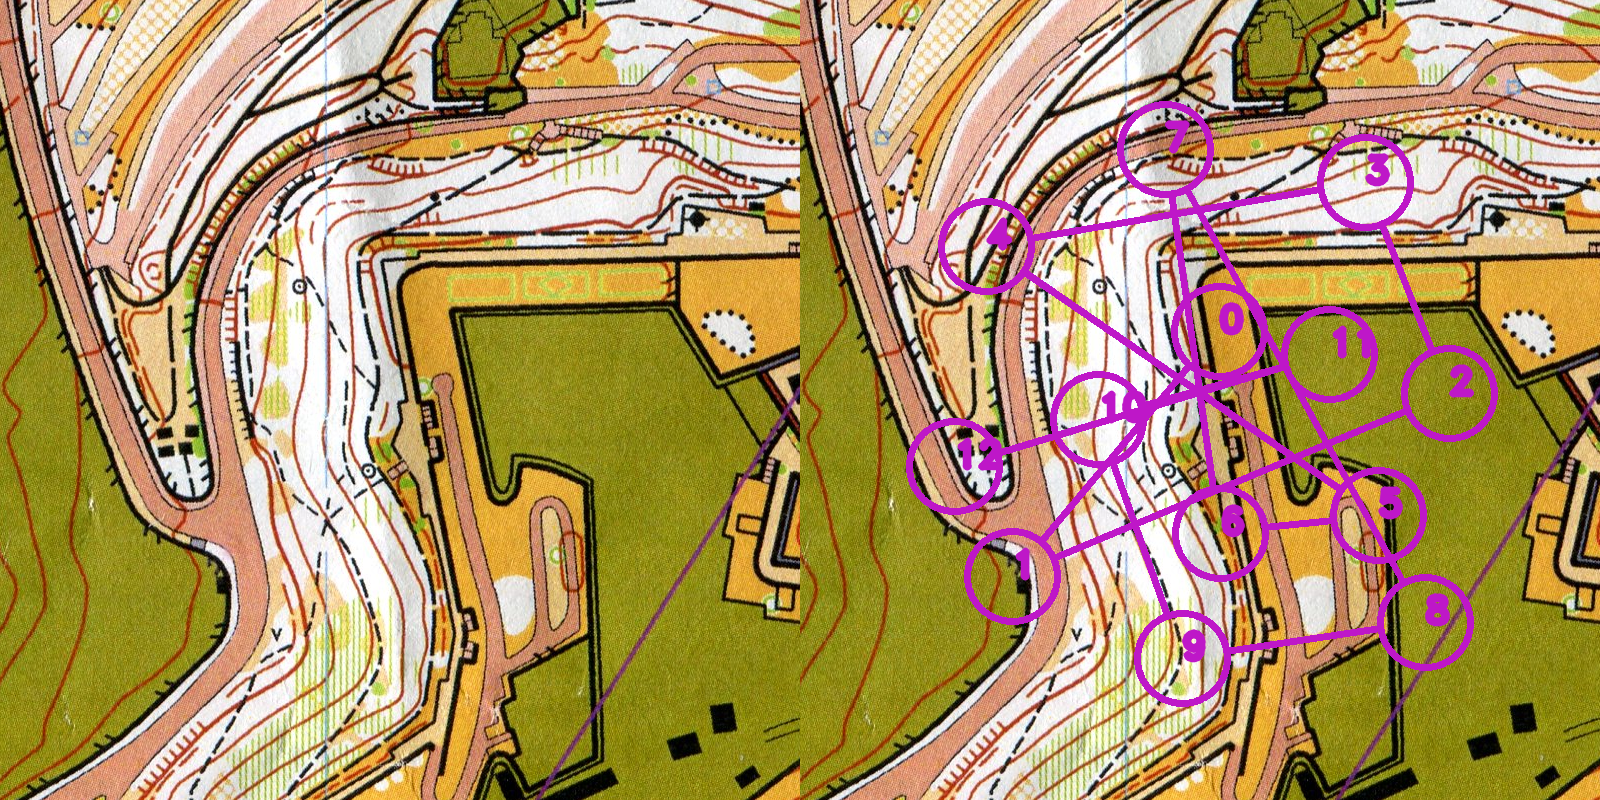

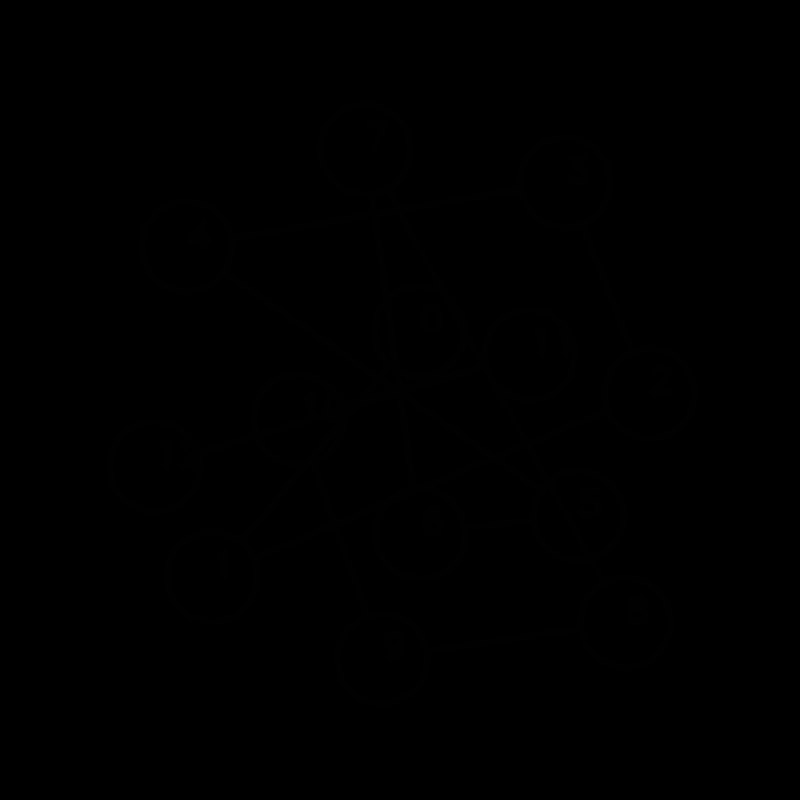

In [9]:
# colors = []
training = np.zeros([20, 800, 800, 3])
training_masks = np.zeros([20, 800, 800])
training_target = np.zeros([20, 800, 800, 3])
validation = np.zeros([4, 600, 600, 3])
validation_masks = np.zeros([4, 600, 600])
validation_target = np.zeros([4, 600, 600, 3])


def get_random_crop(image, crop_height, crop_width):

    max_x = image.shape[1] - crop_width
    max_y = image.shape[0] - crop_height
    # print([max_x, max_y])

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = image[y: y + crop_height, x: x + crop_width]

    return crop


for i in range(4):
  j = 0
  for data in training_data:
    pic = cv2.imread(data)

    pic = get_random_crop(pic, 800, 800)

    # r = random.randrange(0, 4)
    # if r == 1:
    #   pic = cv2.rotate(pic, cv2.ROTATE_90_CLOCKWISE)
    # elif r == 2:
    #   pic = cv2.rotate(pic, cv2.ROTATE_90_COUNTERCLOCKWISE)
    # elif r == 3:
    #   pic = cv2.rotate(pic, cv2.ROTATE_180)
    training_target[i*5 + j] = pic

    b, g, r, circle_radius, num_circles, line_thickness = random.randrange(0, 255), random.randrange(0, 100), random.randrange(160, 255), random.randrange(25, 50), random.randrange(5, 15), random.randrange(5, 10)
    color = [b, g, r]
    lined_pic = generate_figures(pic, color, circle_radius, num_circles, line_thickness)
    training[i*5 + j] = lined_pic

    mask = generate_mask(lined_pic, color)
    # BW mask
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask[mask != 0] = 1
    training_masks[i*5 + j] = mask

    j+=1
  numpy_horizontal_concat = np.concatenate((training_target[i], training[i]), axis=1)
  cv2_imshow(numpy_horizontal_concat)
  cv2_imshow(training_masks[i])
i = 0
for data in validation_data:
  pic = cv2.imread(data)

  pic = get_random_crop(pic, 600, 600)
  validation_target[i] = pic

  b, g, r, circle_radius, num_circles, line_thickness = random.randrange(0, 255), random.randrange(0, 100), random.randrange(160, 255), random.randrange(40, 65), random.randrange(5, 15), random.randrange(5, 10)
  color = [b, g, r]
  lined_pic = generate_figures(pic, color, circle_radius, num_circles, line_thickness)
  validation[i] = lined_pic

  mask = generate_mask(lined_pic, color)
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  mask[mask != 0] = 1
  validation_masks[i] = mask

  i+=1




In [10]:
# gray = cv2.cvtColor(training[0], cv2.COLOR_BGR2GRAY)
# gray = cv2.medianBlur(gray, 5)

# src = np.zeros(training[0].shape)
# rows = gray.shape[0]
# circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, rows / 8,
#                             param1=150, param2=30,
#                             minRadius=30, maxRadius=65)


# if circles is not None:
#     circles = np.uint16(np.around(circles))
#     radius = [circle[2] for circle in circles[0, :]]
#     average_radius = int(sum(radius) / len(radius))
#     for i in circles[0, :]:
#         center = (i[0], i[1])
#         radius = i[2]
#         cv2.circle(src, center, average_radius, (255, 0, 255), 3)


# cv2_imshow(src)
# cv2.waitKey(0)

# # laplacian = cv2.Laplacian(img_gray,cv2.CV_64F)
# cv2_imshow(gray)

In [17]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 1, kernel_size=1, padding=0),
            # nn.Conv2d(3, 16, kernel_size=5, padding=2),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(16, 1, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

        def weights_init(m):
          if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

        self.features.apply(weights_init)
        torch.nn.utils.clip_grad_norm_(self.features.parameters(), max_norm=1)



    def forward(self, x):
        return self.features(x)

class SimpleModel(nn.Module):
  def __init__(self):
        super(simpleModel, self).__init__()

        self.features = nn.Sequential(
                nn.Conv2d(3, 5, 3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d((2, 2)),
                nn.Conv2d(5, 5, 3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d((2, 2)),
                nn.Conv2d(5, 5, 3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d((2, 2)),
                nn.Conv2d(5, 5, 3,padding=1),
                nn.ReLU(),
                nn.MaxPool2d((2, 2)),
                nn.Conv2d(5, 5, 3,padding=1),
                nn.ReLU(),
                nn.Upsample(scale_factor=2),
                nn.Conv2d(5, 5, 3,padding=1),
                nn.ReLU(),
                nn.Upsample(scale_factor=2),
                nn.Conv2d(5, 5, 3,padding=1),
                nn.ReLU(),
                nn.Upsample(scale_factor=2),
                nn.Conv2d(5, 5, 3,padding=3),
                nn.ReLU(),
                nn.Upsample(scale_factor=2),
                nn.Conv2d(5, 1, 3, padding=1),
                nn.Sigmoid()
              )

        def weights_init(m):
          if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

        self.features.apply(weights_init)
        torch.nn.utils.clip_grad_norm_(self.features.parameters(), max_norm=1)
  def forward(self, x):
    return self.features(x)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # input images 1 * 200 * 200
        self.L1 = nn.Sequential(nn.Conv2d(3, 32, 5), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2, 2))  # 32 * 98 * 98
        self.L2 = nn.Sequential(nn.Conv2d(32, 64, 3), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2))  # 64 * 48 * 48
        self.L3 = nn.Sequential(nn.Conv2d(64, 128, 3), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2))  # 128 * 23 * 23
        self.L4 = nn.Sequential(nn.Conv2d(128, 128, 3), nn.BatchNorm2d(128), nn.ReLU())  # 128 * 21 * 21
        self.L5 = nn.Sequential(nn.Conv2d(128, 4, 1), nn.BatchNorm2d(4), nn.ReLU())  # 4 * 21 * 21
        self.FC = nn.Sequential(nn.Linear(4 * 21* 21, 256), nn.ReLU(), nn.Linear(256, 16), nn.ReLU())
        self.Last = nn.Linear(16, 1)

    def forward(self, x):
        x = self.L5(self.L4(self.L3(self.L2(self.L1(x)))))
        B, C, H, W = x.shape
        x = x.view(-1, C * H * W)
        x = self.FC(x)
        x = self.Last(x)
        return x

In [44]:
# transform = transforms.Compose([
#     transforms.RandomCrop((200, 200)),  # Adjust the size as needed
#     transforms.ToTensor(),
# ])

bw_t_masks_tensor = torch.tensor(training_masks).unsqueeze(1).to(torch.float32)
bw_v_masks_tensor = torch.tensor(validation_masks).unsqueeze(1).to(torch.float32)

training_tensor = torch.tensor(training).permute(0,3,1,2).to(torch.float32)
validation_tensor = torch.tensor(validation).permute(0,3,1,2).to(torch.float32)

crop_params = transforms.RandomCrop.get_params(training_tensor, (200, 200))
resized_images = functional.crop(training_tensor, *crop_params)
resized_masks = functional.crop(bw_t_masks_tensor, *crop_params)

crop_params = transforms.RandomCrop.get_params(validation_tensor, (200, 200))
resized_val_images = functional.crop(validation_tensor, *crop_params)
resized_val_masks = functional.crop(bw_v_masks_tensor, *crop_params)

# Define your custom dataset class and transformations
training_with_labels = combined_data = list(zip(resized_images, resized_masks))
validation_with_labels = combined_data = list(zip(resized_val_images, resized_val_masks))

# Create data loaders

train_loader = DataLoader(training_with_labels, batch_size=20, shuffle=True)
val_loader = DataLoader(validation_with_labels, batch_size=5)

# Define the model
model = SimpleCNN()

#
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    for images, masks in train_loader:


        optimizer.zero_grad()
        outputs = model(images)

        # if (epoch % 20 == 0):
        #   cv2_imshow(images[0].permute(1, 2, 0).detach().numpy())

        #   X = outputs[0].permute(1, 2, 0).detach().numpy()
        #   # print(X.max())
        #   cv2_imshow(X * 255)

        #   Y = masks[0].permute(1, 2, 0).detach().numpy()
        #   cv2_imshow(Y * 255)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        for images, masks in val_loader:
            outputs = model(images)
            val_loss = criterion(outputs, masks)
            total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {avg_val_loss}')


# Save the trained model
torch.save(model.state_dict(), 'layer_separation_model.pth')

Epoch 1/1000, Val Loss: 19.686655044555664
Epoch 2/1000, Val Loss: 19.68333625793457
Epoch 3/1000, Val Loss: 19.680004119873047
Epoch 4/1000, Val Loss: 19.6693058013916
Epoch 5/1000, Val Loss: 19.666976928710938
Epoch 6/1000, Val Loss: 19.661516189575195
Epoch 7/1000, Val Loss: 19.65658187866211
Epoch 8/1000, Val Loss: 19.65110969543457
Epoch 9/1000, Val Loss: 19.644054412841797
Epoch 10/1000, Val Loss: 19.639047622680664
Epoch 11/1000, Val Loss: 19.63251304626465
Epoch 12/1000, Val Loss: 19.623348236083984
Epoch 13/1000, Val Loss: 19.619915008544922
Epoch 14/1000, Val Loss: 19.611772537231445
Epoch 15/1000, Val Loss: 19.604150772094727
Epoch 16/1000, Val Loss: 19.597063064575195
Epoch 17/1000, Val Loss: 19.593582153320312
Epoch 18/1000, Val Loss: 19.58538818359375
Epoch 19/1000, Val Loss: 19.5782527923584
Epoch 20/1000, Val Loss: 19.569049835205078
Epoch 21/1000, Val Loss: 19.56243896484375
Epoch 22/1000, Val Loss: 19.556875228881836
Epoch 23/1000, Val Loss: 19.547584533691406
Epoch 2

In [33]:
testers = [cv2.imread(path+element) for element in ["карта 15.png", "карта 13.jpg", "карта 10.png", "карта 9.png", "карта 8.png", "карта 7.png", "карта 6.png",  "карта 5.png"]]
print(testers[0].shape)

(714, 713, 3)


(714, 713, 3)
torch.Size([714, 713])
torch.Size([1, 3, 700, 700])


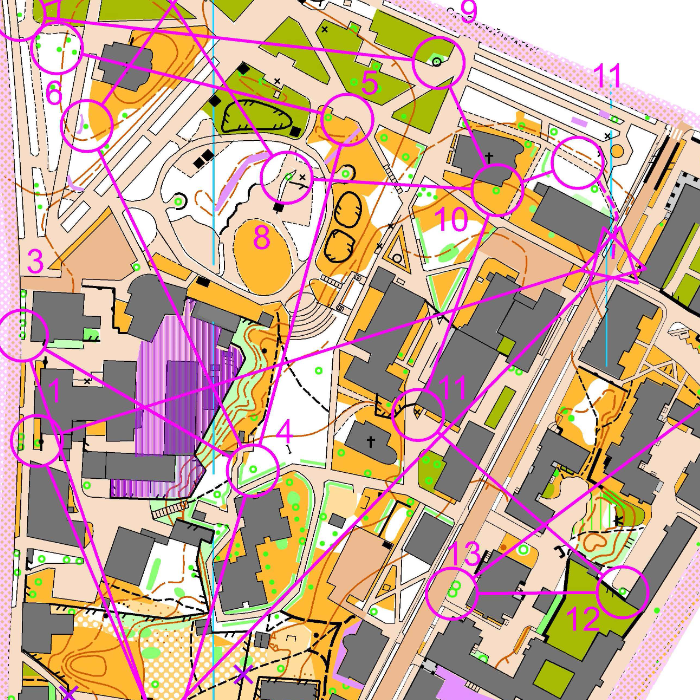

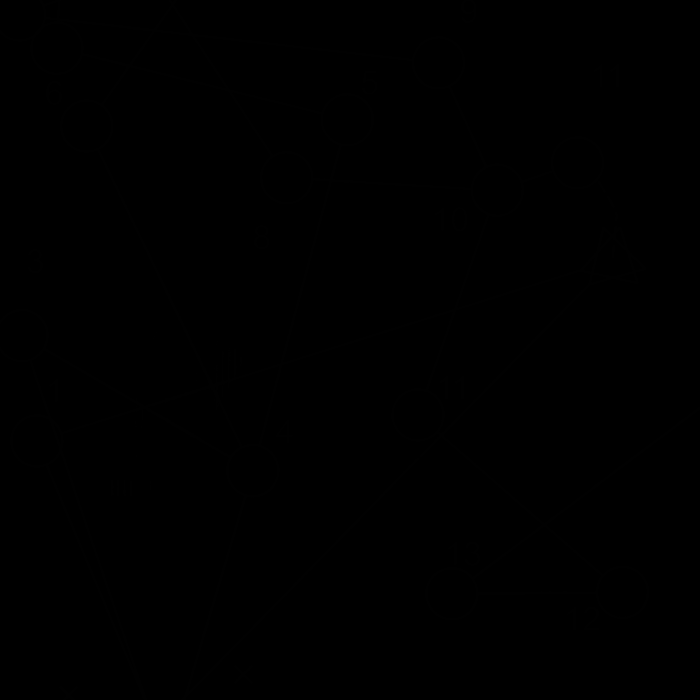

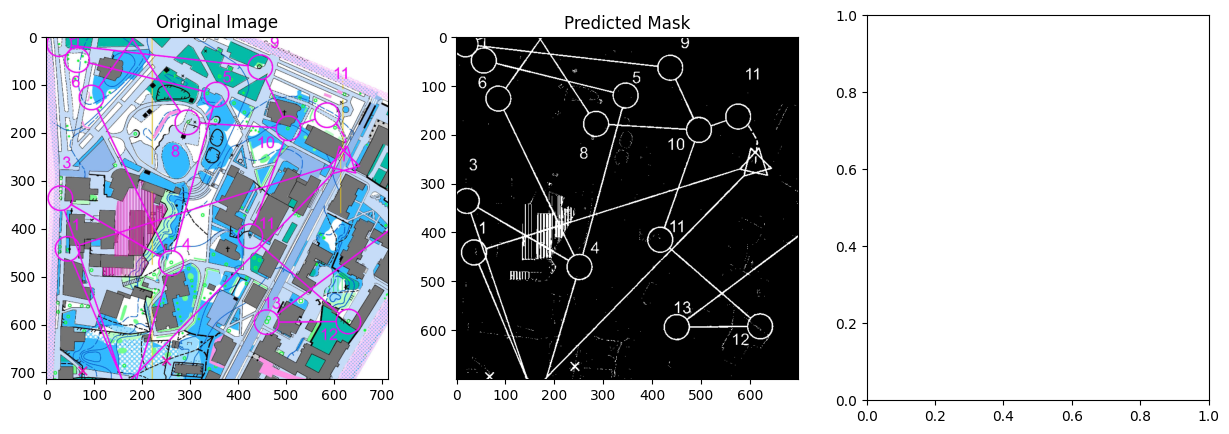

In [45]:
# Load trained weights if available
# model.load_state_dict(torch.load('your_model_weights.pth'))

# Define a DataLoader for testing
# bw_test_data = [cv2.cvtColor(test, cv2.COLOR_BGR2GRAY) for test in test_images]

print(testers[0].shape)

testing_tensor = torch.tensor(testers[0]).permute(2, 0, 1).to(torch.float32)
print(testing_tensor[0].shape)
crop_params = transforms.RandomCrop.get_params(testing_tensor, (700, 700))


resized_test = functional.crop(testing_tensor, *crop_params)


test_loader = DataLoader(resized_test, batch_size=8, shuffle=False)



# Evaluate the model on test data
model.eval()
with torch.no_grad():
    i = 0
    for images in test_loader:

        # Add a batch dimension
        images = images.unsqueeze(0)
        print(images.shape)

        # Assuming the model expects grayscale images (1 channel)
        # images = images[:, :1, :, :]

        outputs = model(images)
        cv2_imshow(images[0].permute(1, 2, 0).detach().numpy())

        cv2_imshow(outputs[0].permute(1, 2, 0).detach().numpy())
        predictions = (outputs > 0.5).float()

        # Convert predictions to PIL image
        # predictions_pil = transforms.ToPILImage()(predictions.squeeze())

        # Overlay predicted binary mask on the original image
        # result_image = Image.blend(Image.fromarray(np.uint8(test_images[0])), predictions_pil, alpha=0.5)

        # Display the original image, predicted mask, and the result
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        axs[0].imshow(testers[i])
        axs[0].set_title("Original Image")

        axs[1].imshow(predictions[i].squeeze(), cmap="gray")
        axs[1].set_title("Predicted Mask")

        # axs[2].imshow(result_image)
        # axs[2].set_title("Result with Lines/Circles Removed")

        plt.show()
        i+=1
